In [76]:
import arviz as az
import numpy as np
import pandas as pd
import pymc as pm
import statsmodels.api as sm
import xarray as xr
from matplotlib import rcParams, pyplot as plt

rcParams['figure.figsize'] = [12, 8]
rcParams['figure.dpi'] = 300

In [64]:
df = pd.read_csv('data/H1.csv', dtype={'LeadTime': float, 'ADR': float})
data = df[['LeadTime', 'ADR']]

In [33]:
data = sm.add_constant(data)
model = sm.OLS(data['ADR'], data[['const', 'LeadTime']])
results = model.fit()
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:                    ADR   R-squared:                       0.001
Model:                            OLS   Adj. R-squared:                  0.001
Method:                 Least Squares   F-statistic:                     37.26
Date:                Tue, 25 Apr 2023   Prob (F-statistic):           1.05e-09
Time:                        19:27:41   Log-Likelihood:            -2.2179e+05
No. Observations:               40060   AIC:                         4.436e+05
Df Residuals:                   40058   BIC:                         4.436e+05
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         93.1688      0.424    219.847      0.0

In [142]:
coords = {
    "x": data['LeadTime'],
    "y": data['ADR'],
}
with pm.Model(coords=coords) as model:
    x = pm.Data('x', data['LeadTime'].values, mutable=False)
    sigma = pm.HalfCauchy("sigma", beta=100, initval=1.0)
    beta = pm.Normal("beta", 0, sigma=100)
    alpha = pm.Normal("alpha", 0, sigma=100)
    y = pm.Normal("y", mu=alpha + beta * x, sigma=sigma, observed=data['ADR'].values)
    idata = pm.sample(5_000, cores=4)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, beta, alpha]


Sampling 4 chains for 1_000 tune and 5_000 draw iterations (4_000 + 20_000 draws total) took 11 seconds.


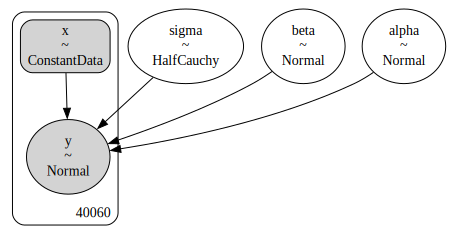

In [143]:
pm.model_to_graphviz(model)

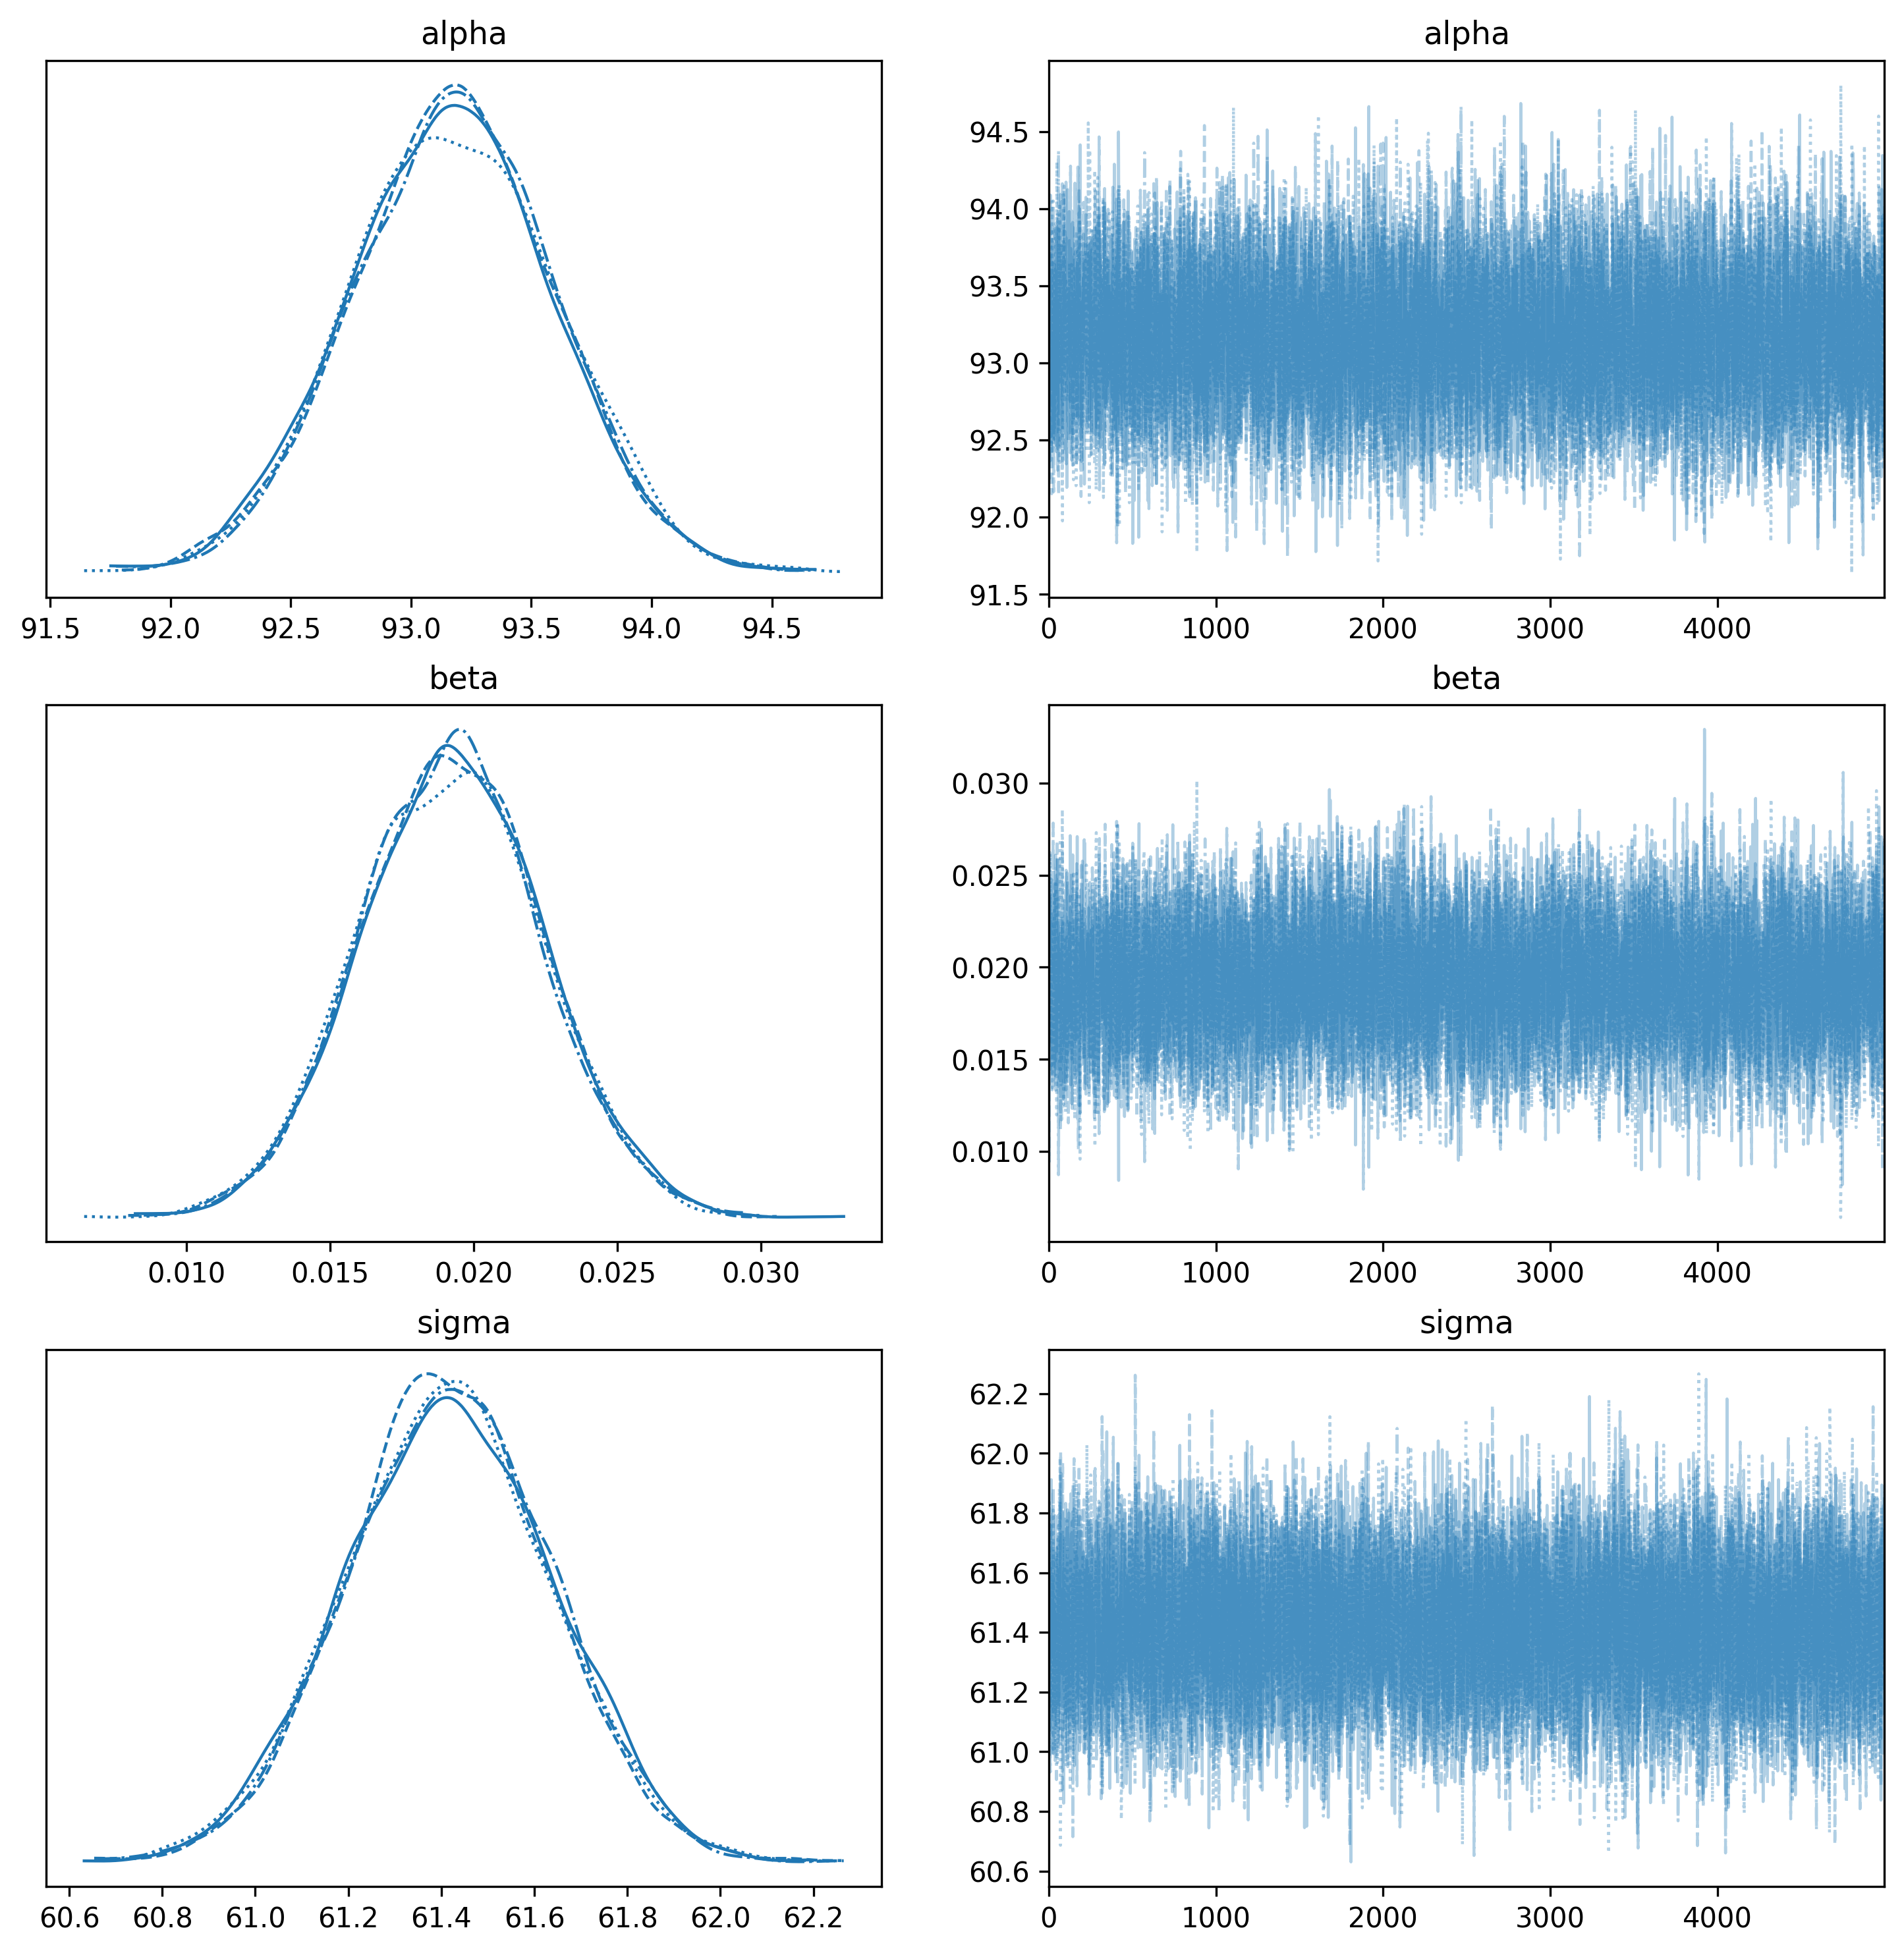

In [144]:
_ = az.plot_trace(idata, var_names=['alpha', 'beta', 'sigma'], figsize=(12, 12))

In [145]:
with model:
    pm.sample_posterior_predictive(idata, extend_inferencedata=True)

Sampling: [y]


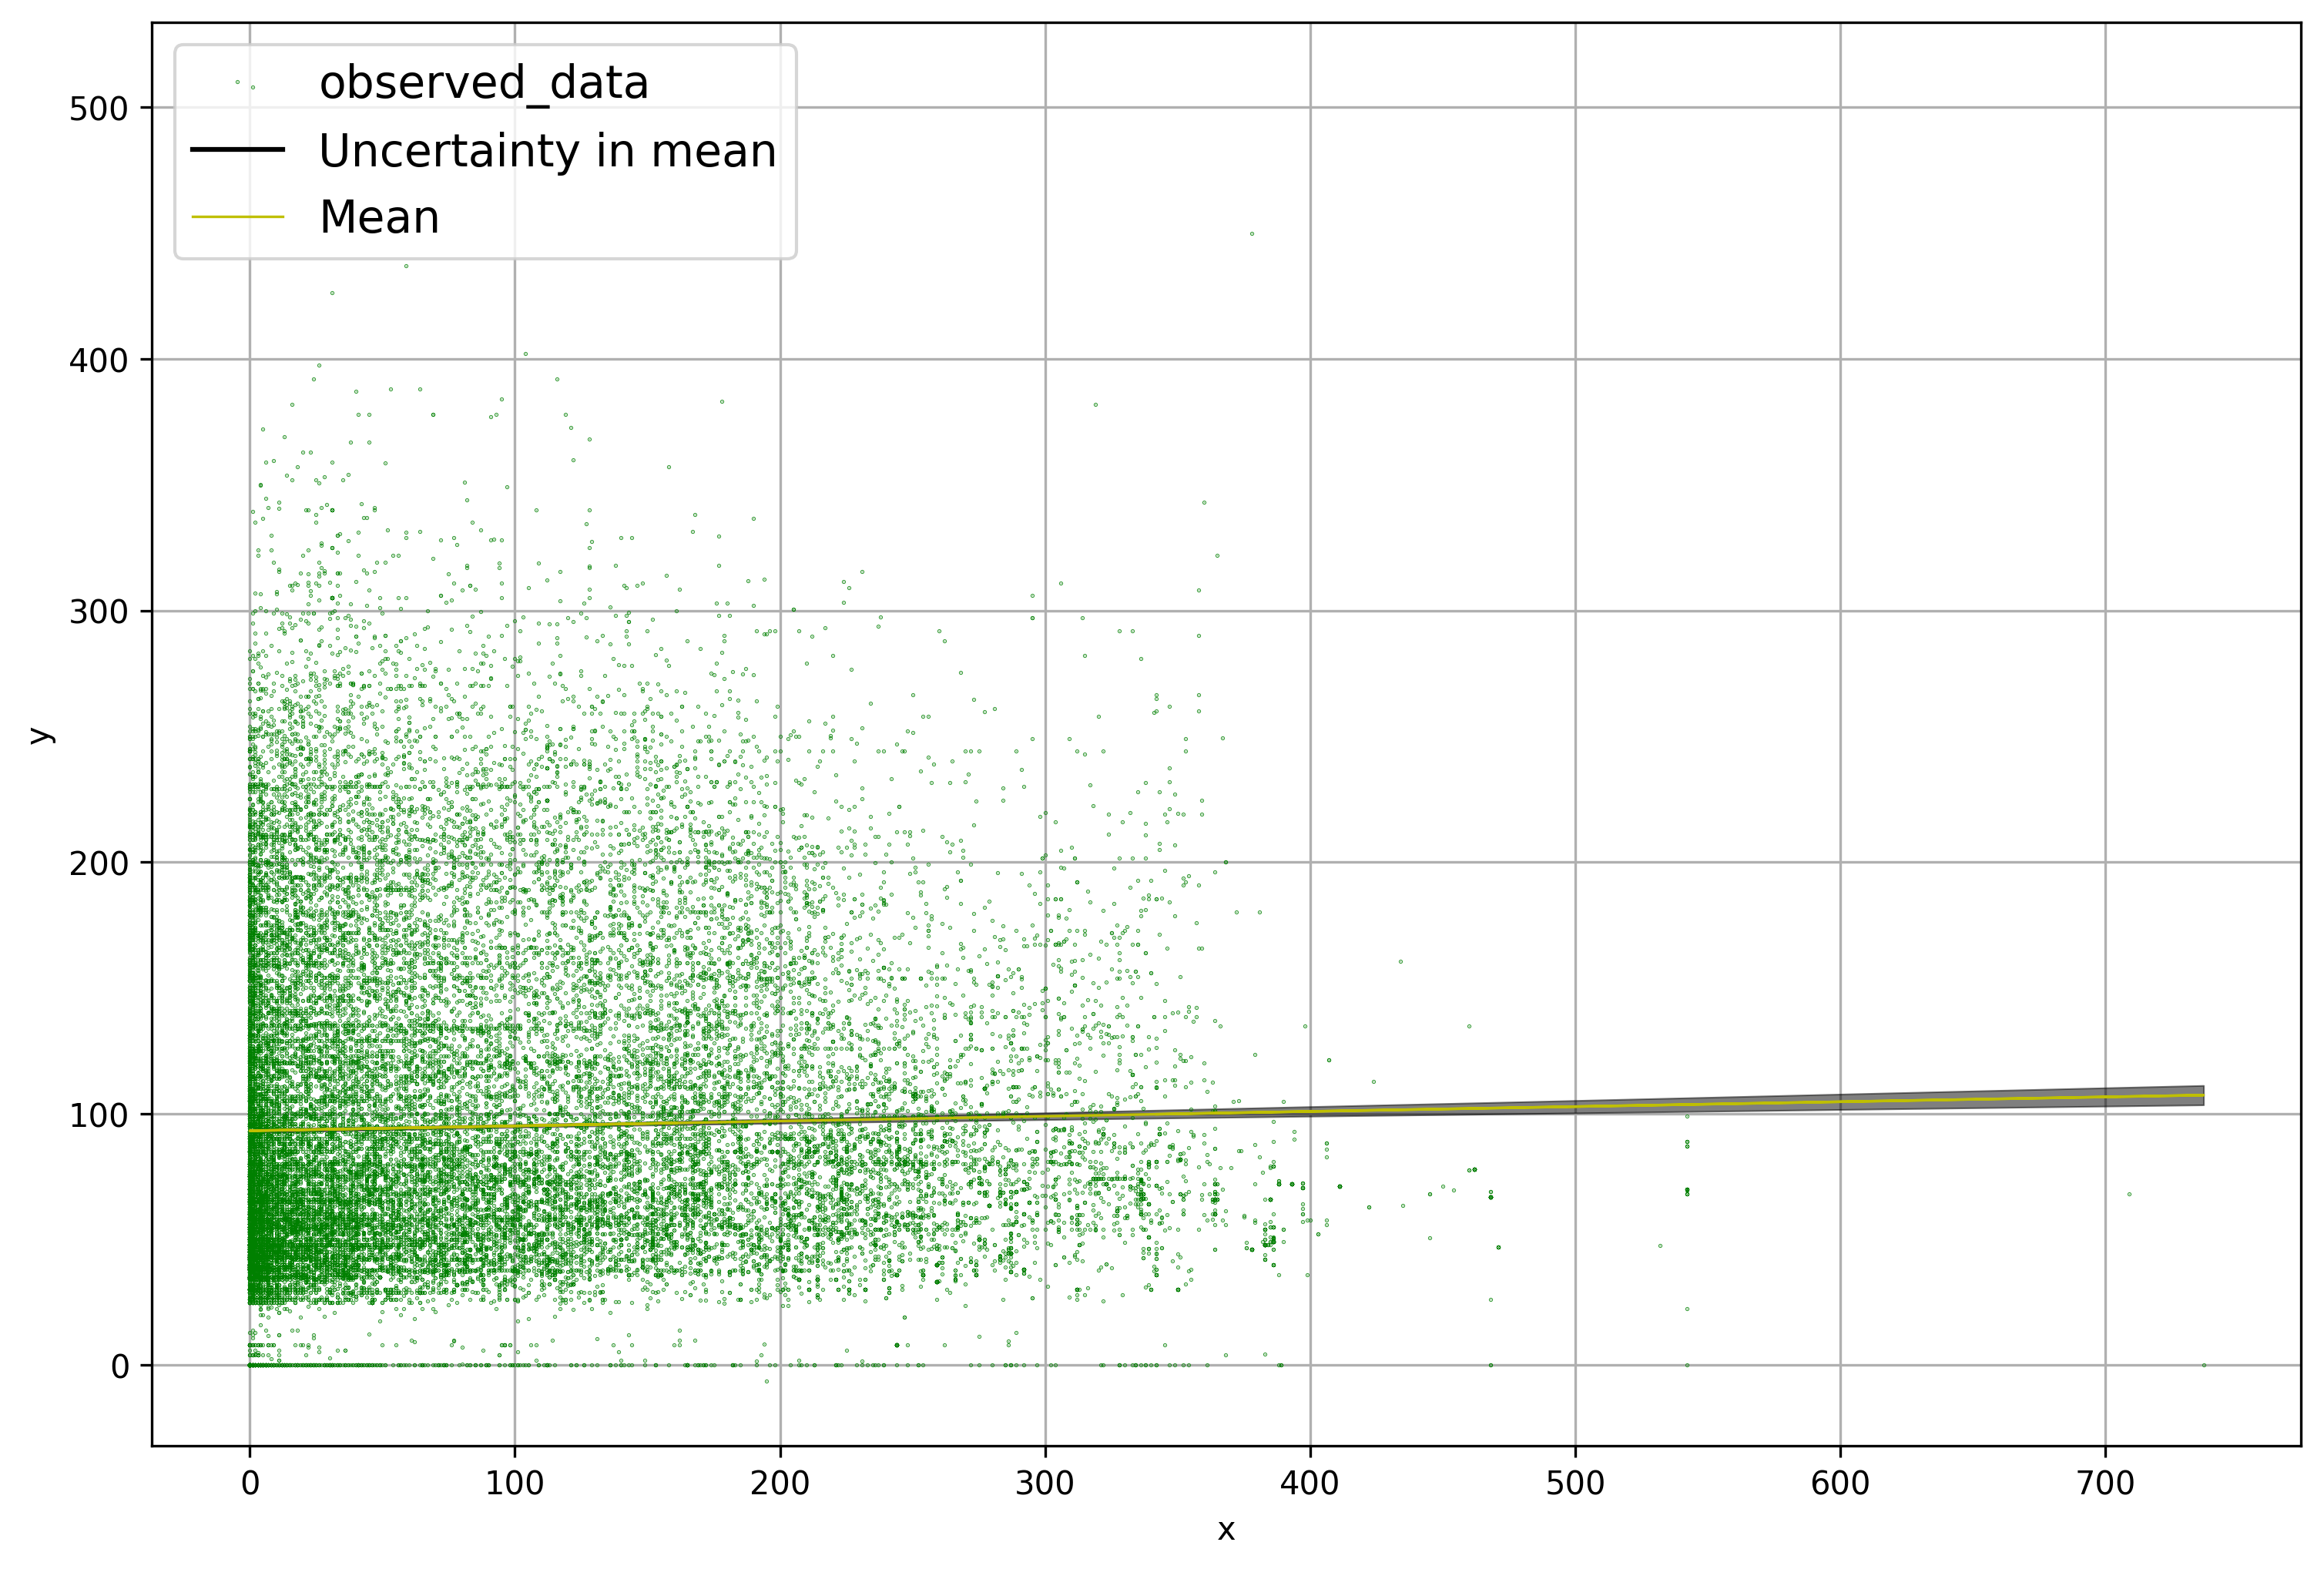

In [146]:
idata.posterior["y_model"] = (
        idata.posterior["alpha"] + idata.posterior["beta"] * idata.constant_data["x"]
)
_ = az.plot_lm(idata=idata,
               x=idata.constant_data['x'],
               y=idata.observed_data['y'],
               y_model=idata.posterior["y_model"],
               kind_pp='hdi', kind_model='hdi',
               y_kwargs={"color": "green", "ms": 0.5, "alpha": 0.8},
               y_hat_fill_kwargs=dict(fill_kwargs={"alpha": 0.8}, color="xkcd:jade"))